<a href="https://colab.research.google.com/github/pranavrelds/Sentiment-analysis-quora-insincere-question-classification/blob/main/Quora_Insincere_Questions_Classification_Random_Forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Libraries

In [59]:
import re
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from scipy.sparse import hstack

from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

%cd /content/drive/MyDrive/Quora Insincere Questions Classification
from utilities import get_clean_text, get_lemmatization, get_features

/content/drive/MyDrive/Quora Insincere Questions Classification


# Configurations

In [4]:
DIR = '/content/drive/MyDrive/Quora Insincere Questions Classification/'
DF_TRAIN = pd.read_csv(DIR+'train.csv')

# Base Model with Random Forest


## Preprocessing

In [60]:
# Copy of original dataframe
DF_PREPROCESS = DF_TRAIN.copy()

# Cleaning of text (removal of tags, symbols, stopwords, abbreviations)
DF_PREPROCESS['clean_question_text'] = DF_PREPROCESS['question_text'].apply(lambda x : get_clean_text(x))

# Lemmatize clean text
DF_PREPROCESS['clean_question_text_lemmatized'] = DF_PREPROCESS['clean_question_text'].apply(lambda x : get_lemmatization(x))

# Get feaetures like like number of stopwords, punctuations etc
DF_PREPROCESS =  get_features(DF_PREPROCESS, 'question_text')

# Checkpoint
DF_PREPROCESS.to_csv(DIR+'df_preprocessed.csv', index=False)
DF_PREPROCESS.head(3)

,qid,question_text,target,clean_question_text,clean_question_text_lemmatized,char_counts,char_length,word_counts,avg_wordlength,stopwords_counts,digits_counts,uppercase_counts,titlewords_count,unique_words_count,numbers_count,punctuations_count
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0,how quebec nationalists province nation 1960s,how quebec nationalists province nation 1960s,60,72,13,4.615385,7,1,0,2,13,4,1
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0,do adopted dog encourage people adopt shop,do adopted dog encourage people adopt shop,66,81,16,4.125000,9,1,0,1,15,0,2
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0,why velocity affect time does velocity affect ...,why velocity affect time does velocity affect ...,58,67,10,5.800000,1,0,0,2,8,0,2


## Splitting Data into Train, Test Sets

In [9]:
# Downsamplong majority class(sincere questions) just to speed up the process
sincere = DF_PREPROCESS[DF_PREPROCESS.target == 0]
insincere = DF_PREPROCESS[DF_PREPROCESS.target == 1]

TRAIN_DOWNSAMPLED = pd.concat([resample(
                     sincere,
                     replace = False,
                     n_samples = len(insincere)), insincere])

print('Number of questions in the original data : ', DF_PREPROCESS.shape[0])
print('Number of questions in the downsampled data : ', TRAIN_DOWNSAMPLED.shape[0])

Number of questions in the original data :  1306122
Number of questions in the downsampled data :  161620


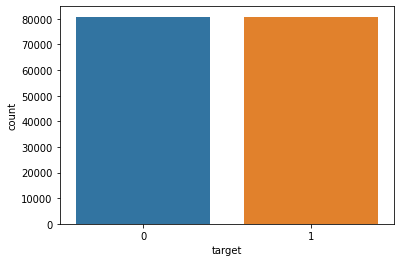

In [17]:
# Distribution of classes after downsampling
sns.countplot(x = TRAIN_DOWNSAMPLED.target)
plt.show()

## Splitting Data into Training and Test Sets

In [32]:
X = TRAIN_DOWNSAMPLED.drop(['qid','target', 'question_text', 'clean_question_text'], axis=1)
y = TRAIN_DOWNSAMPLED['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y ,random_state=0)

print('Number of questions in training set : ', X_train.shape[0])
print('Number of questions in test set : ', X_test.shape[0])

Number of questions in training set :  129296
Number of questions in test set :  32324


## Tfidf Vectors of Cleaned Text Data

In [33]:
tfidf = TfidfVectorizer(stop_words='english', ngram_range=(1, 3))
tfidf.fit_transform(list(DF_PREPROCESS['clean_question_text_lemmatized'].values))

# Transforming X
X_train_tfidf = tfidf.transform(X_train['clean_question_text_lemmatized'].values)
X_test_tfidf = tfidf.transform(X_test['clean_question_text_lemmatized'].values)

print('Shape of training data : ',X_train_tfidf.shape)
print('Shape of test data : ',X_test_tfidf.shape)

Shape of training data :  (129296, 8308880)
Shape of test data :  (32324, 8308880)


In [26]:
# Stacking all the featutes togther columnwise
X_train_stacked = hstack((
    X_train['char_counts'].values.reshape(-1,1),
    X_train['char_length'].values.reshape(-1,1),
    X_train['word_counts'].values.reshape(-1,1),
    X_train['avg_wordlength'].values.reshape(-1,1),
    X_train['stopwords_counts'].values.reshape(-1,1),
    X_train['digits_counts'].values.reshape(-1,1),
    X_train['uppercase_counts'].values.reshape(-1,1),
    X_train['titlewords_count'].values.reshape(-1,1),
    X_train['unique_words_count'].values.reshape(-1,1),
    X_train['numbers_count'].values.reshape(-1,1),
    X_train['punctuations_count'].values.reshape(-1,1),
    X_train_tfidf
    ))

X_test_stacked = hstack((
    X_test['char_counts'].values.reshape(-1,1),
    X_test['char_length'].values.reshape(-1,1),
    X_test['word_counts'].values.reshape(-1,1),
    X_test['avg_wordlength'].values.reshape(-1,1),
    X_test['stopwords_counts'].values.reshape(-1,1),
    X_test['digits_counts'].values.reshape(-1,1),
    X_test['uppercase_counts'].values.reshape(-1,1),
    X_test['titlewords_count'].values.reshape(-1,1),
    X_test['unique_words_count'].values.reshape(-1,1),
    X_test['numbers_count'].values.reshape(-1,1),
    X_test['punctuations_count'].values.reshape(-1,1), 
    X_test_tfidf
    ))

## Model

In [27]:
model_rf = RandomForestClassifier(verbose=2, n_jobs=-1)
model_rf.fit(X_train_stacked, y_train)

# Saving model
pickle.dump(model_rf,open(DIR+'model_rf.pkl','wb'))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 40 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100building tree 12 of 100

building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100building tree 22 of 100

building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100building tree 28 of 100

building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
b

[Parallel(n_jobs=-1)]: Done  72 out of 100 | elapsed: 65.8min remaining: 25.6min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 82.0min finished


## Prediction

In [63]:
y_pred = model_rf.predict(X_test_stacked)
print('\n','Classification Report', '\n', classification_report(y_test, y_pred))

[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done  72 out of 100 | elapsed:    2.5s remaining:    1.0s



 Classification Report 
               precision    recall  f1-score   support

           0       0.85      0.86      0.85     16162
           1       0.86      0.85      0.85     16162

    accuracy                           0.85     32324
   macro avg       0.85      0.85      0.85     32324
weighted avg       0.85      0.85      0.85     32324



[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:    2.9s finished
